# Project 2 - Forecasting Service Metrics

Authors: Tatiana Barrios, Anisha Anandkrishnan

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from pandas import concat
import seaborn as sns

%matplotlib inline

1.Data preparation: Use one of the methods described in Project 1 (Advanced), Task 1 to pre-process the trace. Remove possible outliers. Reduce the dimensionality of the feature space to k = 16 using tree-based feature selection. Then, split the processed trace into training and test samples (x(t),y(t)) by assigning the samples with t < T to the training set and t ≥T to the test set. T is chosen so that the training set contains 70% of the samples.

# Task I - Using linear regression for forecasting

In [26]:
X = pd.read_csv('X.csv')
Y = pd.read_csv('Y.csv')
X.index = pd.to_datetime(X['TimeStamp'])
Y.index = pd.to_datetime(Y['TimeStamp'])
X_dropped = X.drop(labels=["Unnamed: 0", "TimeStamp"], axis=1, inplace=False)
Y_dropped = Y.drop(labels=["Unnamed: 0", "TimeStamp"], axis=1, inplace=False)
X_preprocessed = pd.DataFrame()
X_tmp = preprocessing.StandardScaler().fit_transform(X_dropped)
for i, n in enumerate(X_dropped):
        X_preprocessed[n] = X_tmp[:, i]
        
X_preprocessed.head()

/home/tatiana/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/tatiana/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,0_all_..usr,0_all_..sys,0_all_..iowait,0_all_..soft,0_all_..idle,0_cpu0_.usr,0_cpu0_.sys,0_cpu0_.iowait,0_cpu0_.soft,0_cpu0_.idle,...,36_RxBytes.1,36_TxBytes.1,40_RxPacktes.1,40_TxPacktes.1,40_RxBytes.1,40_TxBytes.1,41_RxPacktes.1,41_TxPacktes.1,41_RxBytes.1,41_TxBytes.1
0,0.069116,1.088334,0.766004,0.573967,-0.579449,1.364018,0.977205,-0.00831,-0.355042,-2.078731,...,1.583733,1.335871,1.090350,1.069987,1.211176,0.975349,1.053685,1.064968,0.971475,1.180097
1,0.247507,2.503497,0.377145,0.573967,-0.865816,1.364018,4.193380,-0.00831,-0.355042,-2.078731,...,1.551250,1.485179,1.190029,1.263907,1.110672,1.287438,1.269613,1.224345,1.294599,1.157325
2,0.158311,1.421314,0.571574,-0.290273,-0.579449,1.384053,0.993448,-0.00831,-0.355042,-1.518028,...,1.636638,1.320954,1.119925,1.012137,1.234329,0.859493,1.037388,1.111521,0.901761,1.236388
3,0.425898,1.421314,0.766004,3.382748,-1.135338,1.404089,-0.630882,-0.00831,2.626215,-0.945519,...,1.503362,1.510045,1.144023,1.126207,1.215636,1.070883,1.113167,1.141096,1.054886,1.212100
4,0.158311,0.006151,5.432315,1.654267,-2.129200,2.355777,2.585292,-0.00831,-0.355042,-2.078731,...,1.556992,1.341298,1.134713,1.095245,1.194114,1.050206,1.113574,1.146025,1.094834,1.186764


In [27]:
X_preprocessed.shape

(14481, 1751)

In [28]:
#converting Y_dropped to make it of the same form as X_preprocessed
Y_new = pd.DataFrame()
Y_tmp=Y_dropped.to_numpy()

for i, n in enumerate(Y_dropped):
        Y_new[n] = Y_tmp[:, i]  
# outlier rejection   
remove = []
for i in X_preprocessed:
    for j in range(len(X_preprocessed[i])):
        if j not in remove and abs(X_preprocessed[i][j]) > 80:
            remove.append(j)
X_clean = X_preprocessed.drop(labels=remove, axis=0, inplace=False)
Y_clean = Y_new.drop(labels=remove, axis=0, inplace=False)

print("Number of dropped samples: ", (len(remove)))
%store X_clean
%store Y_clean

Number of dropped samples:  136
Stored 'X_clean' (DataFrame)
Stored 'Y_clean' (DataFrame)


In [29]:
X_clean.shape

(14345, 1751)

In [30]:
X_clean = X_clean.reset_index()
Y_clean = Y_clean.reset_index()

In [31]:
X_clean = X_clean.drop(X_clean.columns[0], axis=1)
Y_clean = Y_clean.drop(Y_clean.columns[0], axis=1)

In [32]:
X_clean.head()

,0_all_..usr,0_all_..sys,0_all_..iowait,0_all_..soft,0_all_..idle,0_cpu0_.usr,0_cpu0_.sys,0_cpu0_.iowait,0_cpu0_.soft,0_cpu0_.idle,...,36_RxBytes.1,36_TxBytes.1,40_RxPacktes.1,40_TxPacktes.1,40_RxBytes.1,40_TxBytes.1,41_RxPacktes.1,41_TxPacktes.1,41_RxBytes.1,41_TxBytes.1
0,0.069116,1.088334,0.766004,0.573967,-0.579449,1.364018,0.977205,-0.00831,-0.355042,-2.078731,...,1.583733,1.335871,1.090350,1.069987,1.211176,0.975349,1.053685,1.064968,0.971475,1.180097
1,0.247507,2.503497,0.377145,0.573967,-0.865816,1.364018,4.193380,-0.00831,-0.355042,-2.078731,...,1.551250,1.485179,1.190029,1.263907,1.110672,1.287438,1.269613,1.224345,1.294599,1.157325
2,0.158311,1.421314,0.571574,-0.290273,-0.579449,1.384053,0.993448,-0.00831,-0.355042,-1.518028,...,1.636638,1.320954,1.119925,1.012137,1.234329,0.859493,1.037388,1.111521,0.901761,1.236388
3,0.425898,1.421314,0.766004,3.382748,-1.135338,1.404089,-0.630882,-0.00831,2.626215,-0.945519,...,1.503362,1.510045,1.144023,1.126207,1.215636,1.070883,1.113167,1.141096,1.054886,1.212100
4,0.158311,0.006151,5.432315,1.654267,-2.129200,2.355777,2.585292,-0.00831,-0.355042,-2.078731,...,1.556992,1.341298,1.134713,1.095245,1.194114,1.050206,1.113574,1.146025,1.094834,1.186764


In [33]:
Y_clean.head()

,ReadsAvg,WritesAvg
0,59.1331,118.7723
1,59.8588,118.4950
2,57.8251,116.8042
3,63.8154,128.3462
4,57.4993,118.2260


In [59]:
%store -r X_clean
%store -r Y_clean

#Reduce the dimensionality of the feature space 
tree = ExtraTreesRegressor(n_estimators=100, n_jobs=20)
tree = tree.fit(X_clean, Y_clean)
model = SelectFromModel(tree,prefit=True,max_features=16,threshold=-np.inf)
X_fs = model.transform(X_clean)
top_features = []
get_feat = model.get_support()
for i, n in enumerate(X_clean):
    if get_feat[i]:
        top_features.append(n)
feature_name = []
for i in range(16):
    feature_name.append('feature'+str(i+1)+" : "+top_features[i])
X_latest = pd.DataFrame(data = X_fs,columns= feature_name)
Y_latest = pd.DataFrame(data = Y_clean,columns= Y_dropped.columns)
Y_latest = Y_latest.drop(labels=["WritesAvg"], axis=1, inplace=False)
X_latest.head()
Y_latest.head()


,ReadsAvg
0,59.1331
1,59.8588
2,57.8251
3,63.8154
4,57.4993


In [60]:
X_latest.head()

,feature1 : 1_i127_intr.s,feature2 : 4_RxPacktes,feature3 : 4_TxPacktes,feature4 : 4_TxBytes,feature5 : 15_TxBytes,feature6 : 30_RxPacktes,feature7 : 41_RxPacktes,feature8 : 41_TxPacktes,feature9 : 4_RxPacktes.1,feature10 : 4_TxPacktes.1,feature11 : 4_TxBytes.1,feature12 : 17_RxPacktes.1,feature13 : 29_TxPacktes.1,feature14 : 29_TxBytes.1,feature15 : 40_RxPacktes.1,feature16 : 41_TxPacktes.1
0,1.119895,1.039869,1.088463,1.214220,1.184277,1.056585,1.053685,1.064968,1.039869,1.088463,1.214220,1.035805,1.078469,1.165585,1.090350,1.064968
1,0.855128,1.299455,1.238908,1.194544,1.219757,1.201219,1.269613,1.224345,1.299455,1.238908,1.194544,1.299794,1.202829,1.201460,1.190029,1.224345
2,0.879198,1.025629,1.115817,1.240098,1.105230,1.111918,1.037388,1.111521,1.025629,1.115817,1.240098,0.974463,1.110792,1.237204,1.119925,1.111521
3,0.566292,1.138740,1.127852,1.187528,1.172840,1.174922,1.113167,1.141096,1.138740,1.127852,1.187528,1.117959,1.183655,1.189385,1.144023,1.141096
4,0.939372,1.112293,0.980143,1.005623,1.167679,1.125067,1.113574,1.146025,1.112293,0.980143,1.005623,1.111387,1.119557,1.219838,1.134713,1.146025


In [61]:
Y_latest.shape

(14345, 1)

In [62]:
Y_latest.tail()

,ReadsAvg
14476,55.6183
14477,52.6730
14478,52.1335
14479,52.1671
14480,52.6722


In [68]:
Y_latest = Y_latest.reset_index()

In [69]:
Y_latest = Y_latest.drop(Y_latest.columns[0], axis=1)

In [70]:
Y_latest.tail()

,ReadsAvg
14340,55.6183
14341,52.6730
14342,52.1335
14343,52.1671
14344,52.6722


In [71]:
#splitting the processed trace into training and test samples and time index sorting
X_train, X_test, Y_train, Y_test = train_test_split(X_latest, Y_latest, test_size=0.3, shuffle = False)
print(X_train.shape,"(70% of the samples in training set and 16 features)")
X_train = X_train.sort_index(axis = 0)
X_test = X_test.sort_index(axis = 0)
Y_train = Y_train.sort_index(axis = 0)
Y_test = Y_test.sort_index(axis = 0)


## T is the index 9285

(10041, 16) (70% of the samples in training set and 16 features)


In [74]:
X_train.tail()

,feature1 : 1_i127_intr.s,feature2 : 4_RxPacktes,feature3 : 4_TxPacktes,feature4 : 4_TxBytes,feature5 : 15_TxBytes,feature6 : 30_RxPacktes,feature7 : 41_RxPacktes,feature8 : 41_TxPacktes,feature9 : 4_RxPacktes.1,feature10 : 4_TxPacktes.1,feature11 : 4_TxBytes.1,feature12 : 17_RxPacktes.1,feature13 : 29_TxPacktes.1,feature14 : 29_TxBytes.1,feature15 : 40_RxPacktes.1,feature16 : 41_TxPacktes.1
10036,1.083791,0.890140,0.862522,0.921023,0.847371,0.857713,0.888683,0.897375,0.890140,0.862522,0.921023,0.838634,0.863714,0.930262,0.876752,0.897375
10037,0.999547,0.870610,0.846657,0.905672,0.845140,0.860453,0.813719,0.844250,0.870610,0.846657,0.905672,0.755385,0.859332,0.898441,0.851011,0.844250
10038,0.975477,0.833584,0.861975,0.919101,0.873696,0.842374,0.860164,0.863419,0.833584,0.861975,0.919101,0.829324,0.836870,0.900591,0.871276,0.863419
10039,1.107860,0.879968,0.880576,0.925998,0.913781,0.859905,0.832460,0.882588,0.879968,0.880576,0.925998,0.871496,0.867001,0.919159,0.867989,0.882588
10040,1.023616,0.860438,0.870728,0.884023,0.911640,0.908664,0.867905,0.872729,0.860438,0.870728,0.884023,0.896142,0.913568,0.914619,0.883325,0.872729


In [75]:
X_test.head()

,feature1 : 1_i127_intr.s,feature2 : 4_RxPacktes,feature3 : 4_TxPacktes,feature4 : 4_TxBytes,feature5 : 15_TxBytes,feature6 : 30_RxPacktes,feature7 : 41_RxPacktes,feature8 : 41_TxPacktes,feature9 : 4_RxPacktes.1,feature10 : 4_TxPacktes.1,feature11 : 4_TxBytes.1,feature12 : 17_RxPacktes.1,feature13 : 29_TxPacktes.1,feature14 : 29_TxBytes.1,feature15 : 40_RxPacktes.1,feature16 : 41_TxPacktes.1
10041,1.119895,0.860438,0.841733,0.926773,0.933630,0.858261,0.792127,0.842607,0.860438,0.841733,0.926773,0.865472,0.857688,0.932650,0.844439,0.842607
10042,1.180069,0.862879,0.872369,0.907818,0.920929,0.879628,0.852831,0.870539,0.862879,0.872369,0.907818,0.884641,0.878506,0.912441,0.863060,0.870539
10043,1.119895,0.856776,0.919418,0.882061,0.883211,0.876888,0.933091,0.920926,0.856776,0.919418,0.882061,0.922432,0.875767,0.868774,0.914543,0.920926
10044,0.975477,0.833177,0.894252,0.947562,0.950526,0.892228,0.874831,0.895732,0.833177,0.894252,0.947562,0.850684,0.892202,0.957691,0.895921,0.895732
10045,0.951407,0.877120,0.851581,0.919461,0.898870,0.859357,0.842646,0.853013,0.877120,0.851581,0.919461,0.873139,0.860427,0.891108,0.853202,0.853013


In [76]:
Y_test.head()

,ReadsAvg
10041,59.4228
10042,59.7941
10043,59.6689
10044,58.4393
10045,57.2402


2. Create a new training set and a new test set with samples of structure ([x(t−l); ... x(t)]; [y(t);... y(t+h)]). For the KV service, h is incremented and l is decremented by 1 sec intervals between samples. 

3. Using linear regression, train models for l = 0; ::; 10 in the feature space and h = 0; ::; 10 in the target space. The model with l = 0 corresponds to prediction using the current sample. A model with l > 0 corresponds to learning on l samples into the past and predicting 0; :::; 10 steps into the future. Evaluate the models by computing the error (NMAE) on the test set. Display the results in a table with rows representing the time horizon h = 0; ::; 10 and columns representing the lag l = 0; ::; 10. You need to train one model for each lag value (11 models in total).

In [77]:
#NMAE
def nmae(y, y_hat):
    y_av = np.mean(y)
    y_sum = np.sum(np.abs(y - y_hat))
    return y_sum/(len(y)*y_av)

In [78]:
def future_columns(df, h):
    nv = df.shape[1]
    original_names = df.columns
    col, names = list(), list()
    for i in range(0, h+1):
        col.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (original_names[j])) for j in range(nv)]
        else:
            names += [('%s(t+%d)' % (original_names[j], i)) for j in range(nv)]
    concated_ = concat(col, axis=1)
    concated_.columns = names
    
    #This might bring errors, but i dont know if its better to drop them or to fill them at this point
    concated_.fillna(0, inplace=True)
    return concated_
    

In [79]:
def past_values(df, l):
    nv = df.shape[1]
    original_names = df.columns
    col, names = list(), list()
    for i in range(l, -1, -1):
        col.append(df.shift(i))
        if i == 0:
            names += [('%s(t)' % (original_names[j])) for j in range(nv)]
        else:
            names += [('%s(t+%d)' % (original_names[j], i)) for j in range(nv)]
    concated_ = concat(col, axis=1)
    concated_.columns = names
    
    #This might bring errors, but i dont know if its better to drop them or to fill them at this point
    concated_.fillna(0, inplace=True)
    return concated_

In [80]:
def nmaes_array(df_test, df_pre, h):
    nmaes = []
    for i in range(0, h+1):
        y_predict_i = df_pre[:, i]
        y_test_o = df_test.iloc[:, i].to_numpy()
        nmaes.append(nmae(y_test_o, y_predict_i))
    return nmaes

In [81]:
# we only need to train a model for each lag value and 
# meanwhile set the horizon value to 10, then the total number of models is 11.
# This means horizon value is always 10 for all lag values, otherwise we would have to train 121 models
Y_new_test = future_columns(Y_test, 10)
Y_new_train = future_columns(Y_train, 10)

In [82]:
Y_new_train.shape

(10041, 11)

In [83]:
# l = 0 A model with l > 0 corresponds to learning on l samples into the past and predicting 0; :::; 10 steps into the future
reg_l0 = MultiOutputRegressor(LinearRegression()).fit(X_train, Y_new_train)

In [84]:
Y_predict_l0 = reg_l0.predict(X_test) 

In [85]:
h = 10
nmaes_l0 = nmaes_array(Y_new_test, Y_predict_l0, h)

In [86]:
# l = 1
X_train_l1 = past_values(X_train, 1)
X_test_l1 = past_values(X_test, 1)
reg_l1 = MultiOutputRegressor(LinearRegression()).fit(X_train_l1, Y_new_train)
Y_predict_l1 = reg_l1.predict(X_test_l1) 
nmaes_l1 = nmaes_array(Y_new_test, Y_predict_l1, h)

In [87]:
d = {'nmaes_l0': nmaes_l0, 'nmaes_l1': nmaes_l1}
nmaesdf = pd.DataFrame(data=d)
nmaesdf.head()

,nmaes_l0,nmaes_l1
0,0.031264,0.029403
1,0.027512,0.026217
2,0.025726,0.025804
3,0.026760,0.027050
4,0.028625,0.029147


In [88]:
for i in range(2,11):
    X_train_l = past_values(X_train, i)
    X_test_l = past_values(X_test, i)
    reg_l = MultiOutputRegressor(LinearRegression()).fit(X_train_l, Y_new_train)
    Y_predict_l = reg_l.predict(X_test_l) 
    nmaes_l = nmaes_array(Y_new_test, Y_predict_l, h)
    nmaesdf['nmaes_l'+str(i)] = nmaes_l

In [89]:
%store nmaesdf

Stored 'nmaesdf' (DataFrame)


In [90]:
nmaesdf

,nmaes_l0,nmaes_l1,nmaes_l2,nmaes_l3,nmaes_l4,nmaes_l5,nmaes_l6,nmaes_l7,nmaes_l8,nmaes_l9,nmaes_l10
0,0.031264,0.029403,0.027921,0.027615,0.027406,0.027237,0.027024,0.026847,0.026818,0.026838,0.026852
1,0.027512,0.026217,0.026215,0.026261,0.026266,0.026172,0.026029,0.026104,0.026204,0.026251,0.026285
2,0.025726,0.025804,0.025950,0.026134,0.026200,0.026048,0.026091,0.026144,0.026223,0.026287,0.026274
3,0.026760,0.027050,0.027372,0.027666,0.027652,0.027636,0.027540,0.027592,0.027577,0.027668,0.027726
4,0.028625,0.029147,0.029629,0.029707,0.029772,0.029554,0.029551,0.029501,0.029505,0.029638,0.029653
5,0.030524,0.031262,0.031352,0.031388,0.031178,0.031098,0.031006,0.030922,0.030986,0.030981,0.031141
6,0.032410,0.032876,0.032920,0.032605,0.032497,0.032294,0.032133,0.032073,0.032015,0.032159,0.032117
7,0.033674,0.034057,0.033689,0.033511,0.033290,0.033061,0.032954,0.032793,0.032844,0.032800,0.032781
8,0.034617,0.034562,0.034357,0.034045,0.033710,0.033553,0.033313,0.033303,0.033167,0.033155,0.032993
9,0.034570,0.034677,0.034423,0.034033,0.033869,0.033578,0.033505,0.033370,0.033266,0.033104,0.033063


In [91]:
nmaesdf.index

RangeIndex(start=0, stop=11, step=1)

[Text(0, 0.5, 'NMAE'), Text(0.5, 0, 'lag')]

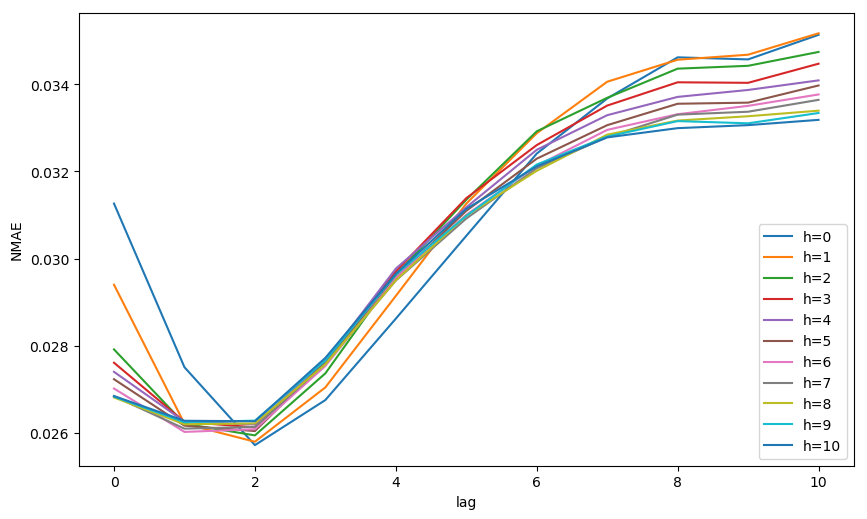

In [92]:
fig, linep_ = plt.subplots(figsize = (10,6), dpi = 100)

linep_ = sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l0", label="h=0")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l1", label="h=1")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l2", label="h=2")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l3", label="h=3")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l4", label="h=4")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l5", label="h=5")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l6", label="h=6")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l7", label="h=7")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l8", label="h=8")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l9", label="h=9")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l10", label="h=10")


linep_.set(xlabel='lag', ylabel='NMAE')

In [215]:
fig.savefig('lags.png', dpi=300, bbox_inches='tight')